In [1]:
import torch
# Is CUDA available now?
print('CUDA available: {}'.format(torch.cuda.is_available()))

CUDA available: True


In [2]:
!conda env list

# conda environments:
#
base                     /home/chirathv97/anaconda3
yolo3dpy37            *  /home/chirathv97/anaconda3/envs/yolo3dpy37



In [3]:
pwd

'/home/chirathv97/FYP/visualDet3D'

In [4]:
!chmod 777 -R /home/chirathv97/FYP/visualDet3D

In [5]:
torch.version.cuda

'11.6'

In [28]:
import sys
# sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from numba import jit
from tqdm import tqdm

In [29]:
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer

In [30]:
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("config/config.py")
is_test_train = True

checkpoint_name = "Stereo3D_latest.pth"

CUDA available: True



.

.

## 01 precomputed values

.

.



In [31]:
# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn

# Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

In [7]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [8]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [174]:
def compute_once(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
#                                       P2.cuda().float(),
                                        p2_carla.cuda().float(),  
                                        p3_carla.cuda().float()
#                                           P3.cuda().float()
                                           ])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    return np.clip(rgb_image, 0, 255)

/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


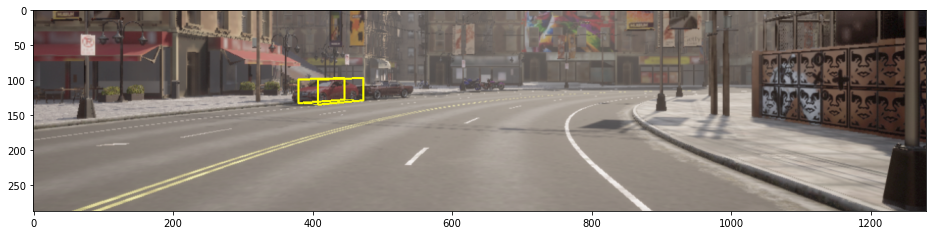

In [47]:
index = 0
fig = plt.figure(figsize=(16,9))
a = compute_once(index)
# a = compute_once_local(index)

/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


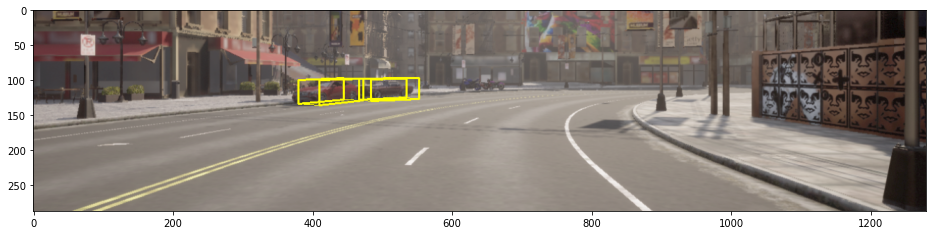

In [48]:
#%matplotlib inline
fig = plt.figure(figsize=(16,9))
index += 1
a = compute_once(index, is_test_train=False, is_draw=True)

767 True


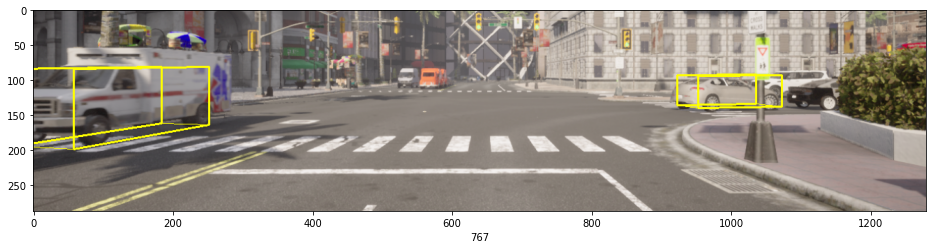

In [176]:
from IPython.display import clear_output

    
for index in range(0,768):
    fig = plt.figure(figsize=(16,9))
    a = compute_once(index, is_test_train=False, is_draw=True)
    clear_output(wait=True)
    print(index,cv2.imwrite(('data/carla 3d %03d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))
    plt.xlabel(index)
    plt.imshow(a)
    plt.show()

.

.
## 02 live feed
.


.

In [51]:
dataset[0]

{'calib': [array([[ 7.17007741e+02,  0.00000000e+00,  6.12589589e+02,
           4.64027932e+01],
         [ 0.00000000e+00,  7.17007741e+02,  8.16404958e+01,
          -8.55397825e-01],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
           4.98101600e-03]]),
  array([[ 7.17007741e+02,  0.00000000e+00,  6.12589589e+02,
          -3.38813848e+02],
         [ 0.00000000e+00,  7.17007741e+02,  8.16404958e+01,
           2.03886223e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
           3.20115300e-03]])],
 'image': [array([[[-0.9362959 , -1.0028011 , -0.88069713],
          [-0.90275896, -0.96851546, -0.88069713],
          [-0.8689843 , -0.9677871 , -0.88069713],
          ...,
          [-1.6384109 , -1.6505601 , -1.2118517 ],
          [-1.6384109 , -1.6505601 , -1.2118517 ],
          [-1.6647708 , -1.6505601 , -1.2386805 ]],
  
         [[-0.9362959 , -1.054228  , -0.88069713],
          [-0.90275896, -0.9695852 , -0.88069713],
          [-0.90

In [71]:
print(len(dataset[0]['image']))
print(dataset[0]['image'][0].shape)
print(dataset[0]['image'][1].shape)

2
(288, 1280, 3)
(288, 1280, 3)


In [158]:
index = 1
name = "%06d" % index
data = dataset[index]
if isinstance(data['calib'], list):
    P2 = data['calib'][0]
    P3 = data['calib'][0]
else:
    P2 = data['calib']
    P3 = 0
print(P2)
print(P2.shape)
print(type(P2))
print(P3)
print(P3.shape)
print(type(P3))

[[ 7.31700203e+02  0.00000000e+00  6.18144642e+02  4.54890727e+01]
 [ 0.00000000e+00  7.31700203e+02  7.38801127e+01 -5.90291493e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.74588400e-03]]
(3, 4)
<class 'numpy.ndarray'>
[[ 7.31700203e+02  0.00000000e+00  6.18144642e+02  4.54890727e+01]
 [ 0.00000000e+00  7.31700203e+02  7.38801127e+01 -5.90291493e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.74588400e-03]]
(3, 4)
<class 'numpy.ndarray'>


In [159]:
P2_0 = np.array(P2)
P3_0 = np.array(P3)
print(P2_0)
print(P3_0)

[[ 7.31700203e+02  0.00000000e+00  6.18144642e+02  4.54890727e+01]
 [ 0.00000000e+00  7.31700203e+02  7.38801127e+01 -5.90291493e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.74588400e-03]]
[[ 7.31700203e+02  0.00000000e+00  6.18144642e+02  4.54890727e+01]
 [ 0.00000000e+00  7.31700203e+02  7.38801127e+01 -5.90291493e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.74588400e-03]]


In [79]:
# np.array([dataset[0]['image'][0]])

In [78]:
# image_l.transpose([0, 3, 1, 2])

In [189]:
image_l = np.array([dataset[0]['image'][0]])
image_l = image_l.transpose([0, 3, 1, 2])
image_l = torch.from_numpy(image_l).float()

image_r = np.array([dataset[0]['image'][1]])
image_r = image_r.transpose([0, 3, 1, 2])
image_r = torch.from_numpy(image_r).float()

In [190]:
print(image_l.shape)
print(type(image_l.shape))

torch.Size([1, 3, 288, 1280])
<class 'torch.Size'>


In [191]:
def collate_fn(batch):
    left_images = np.array([item["image"][0] for item in batch])#[batch, H, W, 3]
    left_images = left_images.transpose([0, 3, 1, 2])
#     print(torch.from_numpy(left_images).float().shape)
#     print(type(torch.from_numpy(left_images).float().shape))
    right_images = np.array([item["image"][1] for item in batch])#[batch, H, W, 3]
    right_images = right_images.transpose([0, 3, 1, 2])

    P2 = [item['calib'][0] for item in batch]
    P3 = [item['calib'][1] for item in batch]
    return torch.from_numpy(left_images).float(), torch.from_numpy(right_images).float(), torch.tensor(P2).float(), torch.tensor(P3).float()

In [192]:
p2_t = data['calib'][0]
print(p2_t)
p2_t = torch.tensor(p2_t).float()
print(torch.tensor(p2_t).float())

p3_t = data['calib'][1]
print(p3_t)
p3_t = torch.tensor(p2_t).float()

[[ 7.31700203e+02  0.00000000e+00  6.18144642e+02  4.54890727e+01]
 [ 0.00000000e+00  7.31700203e+02  7.38801127e+01 -5.90291493e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.74588400e-03]]
tensor([[ 7.3170e+02,  0.0000e+00,  6.1814e+02,  4.5489e+01],
        [ 0.0000e+00,  7.3170e+02,  7.3880e+01, -5.9029e-02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  2.7459e-03]])
[[ 7.31700203e+02  0.00000000e+00  6.18144642e+02 -3.44306231e+02]
 [ 0.00000000e+00  7.31700203e+02  7.38801127e+01  1.95408558e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.72990500e-03]]


/home/chirathv97/anaconda3/envs/yolo3dpy37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/chirathv97/anaconda3/envs/yolo3dpy37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [193]:
P21 = [item['calib'][0] for item in data]
print(P21)

TypeError: string indices must be integers

In [195]:
def collate_fn_live(batch):
        left_images = np.array([item["image"][0] for item in batch])#[batch, H, W, 3]
        left_images = left_images.transpose([0, 3, 1, 2])

        right_images = np.array([item["image"][1] for item in batch])#[batch, H, W, 3]
        right_images = right_images.transpose([0, 3, 1, 2])

        P2 = P2_0
        P3 = P3_0
        return torch.from_numpy(left_images).float(), torch.from_numpy(right_images).float(), torch.tensor(P2).float(), torch.tensor(P3).float()

/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


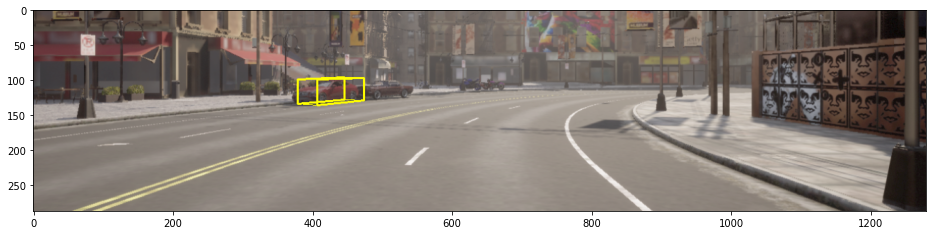

In [199]:
# original_height = data['original_shape'][0]
collated_data = collate_fn([data])
# collated_data = collate_fn_live([data])
# height = collated_data[0].shape[2]
# scale_2d = (original_height - cfg.data.augmentation.crop_top) / height

with torch.no_grad():

    left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
#     left_images, right_images = np.list(image_l), np.list(image_r)

    scores, bbox, obj_names = detector([image_l.cuda().float().contiguous(),
                                      image_r.cuda().float().contiguous(),
                                      p2_carla.cuda().float(),
                                      p3_carla.cuda().float()])

    P2 = P2[0]
    bbox_2d = bbox[:, 0:4]
    bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
    bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
    abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

image = left_images

rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
    for box in bbox_3d_corner_homo:
        box = box.cpu().numpy().T
        rgb_image = draw_3D_box(rgb_image, box)

fig = plt.figure(figsize=(16,9))
plt.imshow(np.clip(rgb_image, 0, 255))

In [151]:
w=1280
h=384
fov=90.0

width = w#int(camera.attributes['image_size_x'])
height = h#int(camera.attributes['image_size_y'])
fov = fov#float(camera.attributes['fov'])

k = np.identity(3)
k[0, 2] = width / 2.0
k[1, 2] = height / 2.0
k[0, 0] = k[1, 1] = width / (2.0 * np.tan(fov * np.pi / 360.0))

ravel_mode = 'C'
intrinsic_mat =   k
P0 = intrinsic_mat
P0 = np.column_stack((P0, np.array([0, 0, 0])))
P0 = np.ravel(P0, order=ravel_mode)
P0

array([640.,   0., 640.,   0.,   0., 640., 192.,   0.,   0.,   0.,   1.,
         0.])

In [167]:
# print(intrinsic_mat.shape)
P0_carla = np.reshape(P0,(3,4))
print(P0_carla.shape)
print(type(P0_carla))
print(P0_carla)

(3, 4)
<class 'numpy.ndarray'>
[[640.   0. 640.   0.]
 [  0. 640. 192.   0.]
 [  0.   0.   1.   0.]]


In [169]:
p2_t = data['calib'][0]
print(p2_t.shape)
print(type(p2_t))
print(p2_t)

(3, 4)
<class 'numpy.ndarray'>
[[ 7.31700203e+02  0.00000000e+00  6.18144642e+02  4.54890727e+01]
 [ 0.00000000e+00  7.31700203e+02  7.38801127e+01 -5.90291493e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.74588400e-03]]


In [170]:
P0_carla = torch.tensor(P0_carla).float()
print(torch.tensor(P0_carla).float())

tensor([[640.,   0., 640.,   0.],
        [  0., 640., 192.,   0.],
        [  0.,   0.,   1.,   0.]])


/home/chirathv97/anaconda3/envs/yolo3dpy37/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [171]:
p2_t = torch.tensor(p2_t).float()
print(torch.tensor(p2_t).float())

tensor([[ 7.3170e+02,  0.0000e+00,  6.1814e+02,  4.5489e+01],
        [ 0.0000e+00,  7.3170e+02,  7.3880e+01, -5.9029e-02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  2.7459e-03]])


/home/chirathv97/anaconda3/envs/yolo3dpy37/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [172]:
p2_carla = P0_carla
p3_carla = P0_carla

In [ ]:
image_l_live
image_r_live

In [ ]:
image_l_live = np.array([dataset[0]['image'][0]])
image_l_live = image_l.transpose([0, 3, 1, 2])
image_l_live = torch.from_numpy(image_l).float()

image_r_live = np.array([dataset[0]['image'][1]])
image_r_live = image_r.transpose([0, 3, 1, 2])
image_r_live = torch.from_numpy(image_r).float()

print(image_l.shape)
print(type(image_l.shape))

In [50]:
from visualDet3D.data.pipeline import build_augmentator

preprocess = build_augmentator(cfg.data.test_augmentation)
image, P2, label = preprocess(original_image, p2=deepcopy(calib.P2), labels=deepcopy(data_frame.label))
_,  P3 = preprocess(original_image, p2=deepcopy(calib.P3))

NameError: name 'original_image' is not defined

In [9]:
def compute_once_live(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
    data = dataset[index]
    
    

    collated_data = dataset.collate_fn_local([data])
    
    
    left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]

    with torch.no_grad():
        
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
    
        P2 = P2[0]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

    image = left_images
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    
    if len(scores) > 0:
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    return np.clip(rgb_image, 0, 255)

In [ ]:
P2, P3 = P2_0 ,P3_0

### live image 

In [200]:
from easydict import EasyDict as edict
import os 
import numpy as np

cfg = edict()

## data
data = edict(
    batch_size = 4,
    num_workers = 4,
    rgb_shape = (288, 1280, 3),
    train_dataset = "KittiStereoDataset",
    val_dataset   = "KittiStereoDataset",
    test_dataset  = "KittiStereoTestDataset",
    train_split_file = os.path.join(cfg.path.visualDet3D_path, 'data', 'kitti', 'test_split', 'train.txt'),
    val_split_file   = os.path.join(cfg.path.visualDet3D_path, 'data', 'kitti', 'test_split', 'val.txt'),
    test_split_file   = os.path.join(cfg.path.visualDet3D_path, 'data', 'kitti', 'test_split', 'test.txt'),
)

data.augmentation = edict(
    rgb_mean = np.array([0.485, 0.456, 0.406]),
    rgb_std  = np.array([0.229, 0.224, 0.225]),
    cropSize = (data.rgb_shape[0], data.rgb_shape[1]),
    crop_top = 100,
)
data.train_augmentation = [
    edict(type_name='ConvertToFloat'),
    edict(type_name='PhotometricDistort', keywords=edict(distort_prob=1.0, contrast_lower=0.5, contrast_upper=1.5, saturation_lower=0.5, saturation_upper=1.5, hue_delta=18.0, brightness_delta=32)),
    edict(type_name='CropTop', keywords=edict(crop_top_index=data.augmentation.crop_top)),
    edict(type_name='Resize', keywords=edict(size=data.augmentation.cropSize)),
    edict(type_name='RandomMirror', keywords=edict(mirror_prob=0.5)),
    edict(type_name='Normalize', keywords=edict(mean=data.augmentation.rgb_mean, stds=data.augmentation.rgb_std))
]
data.test_augmentation = [
    edict(type_name='ConvertToFloat'),
    edict(type_name='CropTop', keywords=edict(crop_top_index=data.augmentation.crop_top)),
    edict(type_name='Resize', keywords=edict(size=data.augmentation.cropSize)),
    edict(type_name='Normalize', keywords=edict(mean=data.augmentation.rgb_mean, stds=data.augmentation.rgb_std))
]
cfg.data = data

AttributeError: 'EasyDict' object has no attribute 'path'

In [ ]:
from visualDet3D.data.pipeline import build_augmentator
transform = build_augmentator(cfg.data.test_augmentation)

In [ ]:
calib, left_image, right_image, _, _ = kitti_data.read_data()
        calib.image_shape = left_image.shape
        label = []
        for obj in kitti_data.label:
            if obj.type in self.obj_types:
                label.append(obj)
        transformed_left_image, transformed_right_image, P2, P3, transformed_label = self.transform(
                left_image, right_image, deepcopy(calib.P2),deepcopy(calib.P3), deepcopy(label)
        )

In [ ]:
left_image = 
right_image = 

In [62]:
def compute_once_live_expected(left_image, right_image,is_draw=True):
    with torch.no_grad():
        scores, bbox, obj_names = detector([left_image.cuda().float().contiguous(),
                                          right_image.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
    
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

    image = left_image
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    
    if len(scores) > 0:
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
            
    if is_draw:plt.imshow(np.clip(rgb_image, 0, 255))

    return np.clip(rgb_image, 0, 255)

In [19]:
index = 0
fig = plt.figure(figsize=(16,9))
# a = compute_once(index)
a = compute_once_live(index)
# a = compute_once_live_expected(index)

In [ ]:
from IPython.display import clear_output

for index in range(0,768):
    fig = plt.figure(figsize=(16,9))
    # a = compute_once(index)
    a = compute_once_live(index)
    # a = compute_once_live_expected(index)
    clear_output(wait=True)
#     print(index,cv2.imwrite(('data/carla 3d %03d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))
    plt.xlabel(index)
    plt.imshow(a)
    plt.show()